In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
from scipy import stats as st
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import graphviz
import time
import math
from sklearn.model_selection import train_test_split

## Data cleaning

In [2]:
nfl = pd.read_csv("nfl_fg.csv")

nfl = nfl.drop("Unnamed: 0", axis=1)

nfl.displayName = nfl.displayName.astype("category")
nfl.homeTeamAbbr = nfl.homeTeamAbbr.astype("category")

nfl = nfl.dropna(subset=["distance"])
nfl = nfl.reset_index()

nfl.seconds = nfl.seconds.astype("float")
# add constant to account for any. 0 values
nfl.seconds = nfl.seconds + 0.001
nfl.seconds = np.log10(nfl.seconds)
nfl.seconds

home_teams = pd.get_dummies(nfl.homeTeamAbbr)
kickers = pd.get_dummies(nfl.displayName)

In [3]:
# standardize

X = nfl[["distance", "seconds", "score_diff"]]
mnX = X.mean().values
stdX = X.std().values
zX = pd.DataFrame(((X - mnX) / stdX).values)

cols = ["distance", "seconds", "diff"]
zX.columns = cols
zX.head()

X = pd.concat([zX, home_teams, kickers], axis=1)
y = nfl["result"]

In [4]:
name = nfl.displayName.values
names = len(nfl.displayName.unique())
name_lookup = dict(zip(nfl.displayName.unique(), range(names)))
name = nfl.displayName.replace(name_lookup).values

distance = nfl.distance.values

stadium = nfl.homeTeamAbbr.values
stadiums = len(nfl.homeTeamAbbr.unique())
stadium_lookup = dict(zip(nfl.homeTeamAbbr.unique(), range(stadiums)))
stadium = nfl.homeTeamAbbr.replace(stadium_lookup).values

In [5]:
X_train, X_test, name_train, name_test, stadium_train, stadium_test, y_train, y_test, distance_train, distance_test = train_test_split(X, name, stadium, y, distance, test_size = 0.33, random_state = 42)

## Bayesian Regression Model

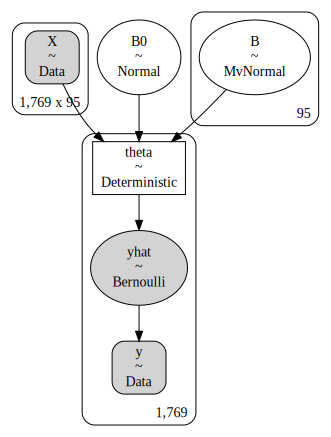

In [6]:
def construct_bayes_regression(model_input, model_output):
    with pm.Model() as bayes_model:
        
        X = pm.Data('X', model_input)
        y = pm.Data('y', model_output)

        B0 = pm.Normal('B0', mu = 0, sd = 1e5)
        B = pm.MvNormal('B', mu = np.zeros(95), cov = np.eye(95) * 1e5, shape = 95)  

        u = B0 + pm.math.dot(X, B)
        theta = pm.Deterministic('theta', pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return bayes_model

bayes_model = construct_bayes_regression(X_train, y_train)
pm.model_to_graphviz(bayes_model)

### Sampling approach

In [7]:
with bayes_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, B0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 85 seconds.
There were 4826 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4891 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4839 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4788 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


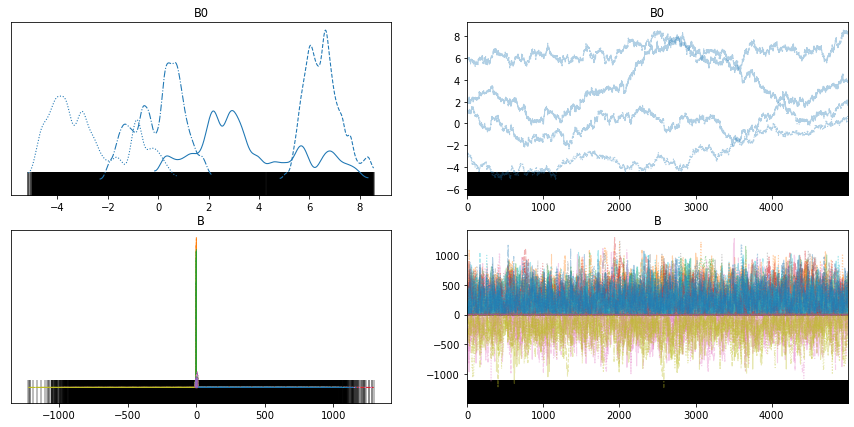

In [8]:
with bayes_model:
    az.plot_trace(trace, var_names=['B0', 'B'], figsize=(15, 7));

In [9]:
with bayes_model:
    print(pm.summary(trace, var_names=['B0', 'B']))

          mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B0       1.848    3.774  -4.298    7.627      1.795    1.364       5.0   
B[0]    -1.494    0.105  -1.679   -1.285      0.005    0.003     543.0   
B[1]     0.117    0.077  -0.038    0.257      0.002    0.002    1228.0   
B[2]    -0.101    0.079  -0.249    0.045      0.003    0.002     836.0   
B[3]     1.428    4.870  -7.140    8.063      2.382    1.818       5.0   
...        ...      ...     ...      ...        ...      ...       ...   
B[90]  249.459  183.078  -2.200  575.819      6.117    4.327     990.0   
B[91]   -1.704    3.453  -6.584    5.060      1.599    1.210       5.0   
B[92]   -1.281    3.415  -5.901    5.340      1.619    1.230       5.0   
B[93]   -0.987    3.439  -5.759    5.887      1.619    1.229       5.0   
B[94]   -1.349    3.367  -5.890    5.200      1.603    1.218       5.0   

       ess_tail  r_hat  
B0         15.0   2.52  
B[0]     1152.0   1.02  
B[1]     1984.0   1.01  
B[2]     14

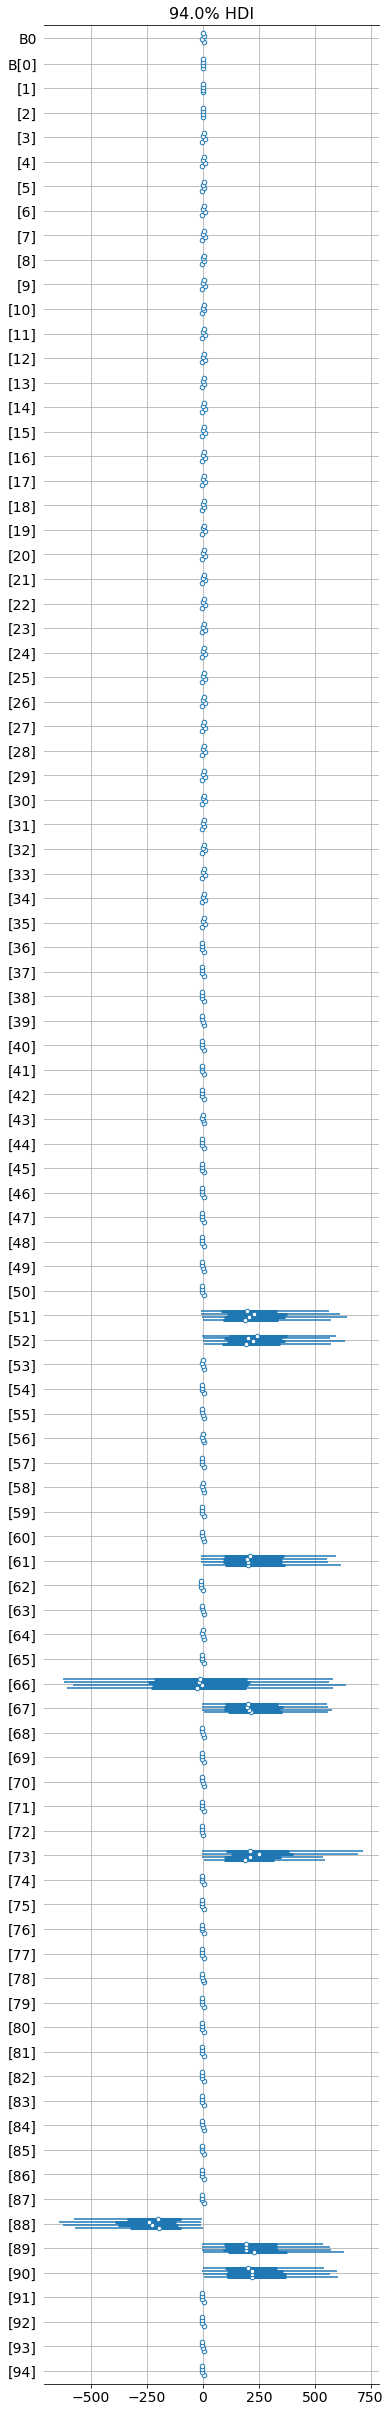

In [11]:
with bayes_model:
    pm.plots.plot_forest(trace, var_names=['B0', 'B'])
    plt.grid()

### Variational approach

In [ ]:
with bayes_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_reg = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [ ]:
pm.set_data({'X': X_test, 'y': y_test}, model = bayes_model)

In [ ]:
with bayes_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_reg, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [ ]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

## Hierarchical Model

In [ ]:
def construct_hierarchical_model(observed, dist, name):
    with pm.Model() as hierarchical_model:

        y = pm.Data("y", observed)
        distance = pm.Data("distance", dist)
        name = pm.Data("name", name_train)

        # priors
        mu_a = pm.Normal("mu_a", mu = 0, sd = 1e5)
        sigma_a = pm.HalfCauchy("sigma_a", 10)
        mu_b = pm.Normal("mu_b", mu = 0, sd = 1e5)
        sigma_b = pm.HalfCauchy("sigma_b", 10)

        # random intercepts
        a = pm.Normal("a", mu = mu_a, sd = sigma_a, shape = names)

        # random slopes
        b = pm.Normal("b", mu = mu_b, sd = sigma_b, shape = names)

        # expected
        u = a[name] + (b[name] * distance)
        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
        return hierarchical_model

hierarchical_model = construct_hierarchical_model(y_train, distance_train, name_train)
pm.model_to_graphviz(hierarchical_model)

In [ ]:
# with hierarchical_model:
#     hierarchical_trace = pm.sample(5000)

In [ ]:
with hierarchical_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_hi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [ ]:
with hierarchical_model:
    pm.plots.plot_forest(sample_advi_hi, var_names=['a', 'b'])
    plt.grid()

In [ ]:
pm.set_data({'y': y_test, 'distance': distance_test, 'name': name_test}, model = hierarchical_model)

In [ ]:
with hierarchical_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_hi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [ ]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

## Multilevel Model

In [ ]:
def construct_multilevel_regression(name_input, stadium_input, distance_input, model_output):
    with pm.Model() as multilevel_model:   
        
        name = pm.Data('name', name_input)
        stadium = pm.Data('stadium', stadium_input)
        distance = pm.Data('distance', distance_input)
        y = pm.Data('y', model_output)       

        # priors
        mu_a_player = pm.Normal("mu_a_player", mu = 0, sd = 1e5)
        sigma_a_player = pm.HalfCauchy("sigma_a_player", 10)
        mu_b_player = pm.Normal("mu_b_player", mu = 0, sd = 1e5)
        sigma_b_player = pm.HalfCauchy("sigma_b_player", 10)


        # random intercepts
        a_player = pm.Normal("a_player", mu = mu_a_player, sd = sigma_a_player, shape = names)

        # random slopes
        b_player = pm.Normal("b_player", mu = mu_b_player, sd = sigma_b_player, shape = names)

        # priors
        mu_a_stadium = pm.Normal("mu_a_stadium", mu = 0, sd = 1e5)
        sigma_a_stadium = pm.HalfCauchy("sigma_a_stadium", 10)
        # mu_b_stadium = pm.Normal("mu_b_stadium", mu = 0, sd = 1e5)
        # sigma_b_stadium = pm.HalfCauchy("sigma_b_stadium", 10)

        # random intercepts
        a_stadium = pm.Normal("a_stadium", mu = mu_a_stadium, sd = sigma_a_stadium, shape = stadiums)

        # random slopes
        # b_stadium = pm.Normal("b_stadium", mu = mu_b_stadium, sd = sigma_b_stadium, shape = stadiums)

        u = a_player[name] + (b_player[name] * distance)  + a_stadium[stadium] + (a_stadium[stadium] * a_player[name])


        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return multilevel_model

multilevel_model = construct_multilevel_regression(name_train, stadium_train, distance_train, y_train)
pm.model_to_graphviz(multilevel_model)

In [ ]:
with multilevel_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_multi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [ ]:
pm.set_data({'name': name_test, 
             'stadium': stadium_test, 
             'distance': distance_test, 
             'y': y_test}, 
            model = multilevel_model)  

In [ ]:
with multilevel_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_multi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [ ]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

In [ ]:
with multilevel_model:
    pm.plots.plot_forest(sample_advi_multi, var_names=['a_player'])
    plt.grid()

## WAIC and BMA

In [ ]:
cmp_df = az.compare({'hierarchical': sample_advi_hi, 'bayesian regression': sample_advi_reg, 
                     'multilevel': sample_advi_multi}, ic = 'WAIC', 
                    method='BB-pseudo-BMA')
cmp_df

In [ ]:
w1 = cmp_df.loc['hierarchical','weight']
w2 = cmp_df.loc['bayesian regression','weight']
w3 = cmp_df.loc['multilevel','weight']
weights = [w1, w2, w3]
y_bma = pm.sample_posterior_predictive_w(traces = [sample_advi_hi, sample_advi_reg, sample_advi_multi],
                                        samples=1000,
                                        models=[hierarchical_model, bayes_model, multilevel_model],
                                        weights=weights)

In [ ]:
# model 1

y_1 = pm.sample_posterior_predictive_w(traces = [sample_advi_hi],
                                        samples=1000,
                                        models=[hierarchical_model])

# model 2

y_2 = pm.sample_posterior_predictive_w(traces = [sample_advi_reg],
                                        samples=1000,
                                        models=[bayes_model])

# model 3

y_3 = pm.sample_posterior_predictive_w(traces = [sample_advi_multi],
                                        samples=1000,
                                        models=[multilevel_model])

In [ ]:
# KDE plots

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_1['yhat'].mean(0), plot_kwargs={'color': 'C1'}, label='Hierarchical Model', ax=ax)
az.plot_kde(y_2['yhat'].mean(0), plot_kwargs={'color': 'C2'}, label='Bayesian Regression Model', ax=ax)
az.plot_kde(y_3['yhat'].mean(0), plot_kwargs={'color': 'C3'}, label='Multilevel Model', ax=ax)
az.plot_kde(y_bma['yhat'].mean(0), plot_kwargs={'color': 'C4'}, label='BMA', ax=ax)

## Unbalanced data

In [ ]:
temp = list(nfl.specialTeamsResult.value_counts())
print(f"{np.round(temp[0]/sum(temp), decimals=2) * 100}% of FG attempts are good in the dataset")

In [ ]:
sns.countplot(x='specialTeamsResult', data=nfl).set_title('Field Goal Results')
plt.show()